# Multiple Comparisons

_This setup code is required to run in an IPython notebook_

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['savefig.dpi'] = 90

try:
    import seaborn
except ImportError:
    pass

# Reproducability
import numpy as np
np.random.seed(23456)
# Common seed used throughout
seed = np.random.randint(0,2**31-1)

Populating the interactive namespace from numpy and matplotlib


The multiple comparison procedures all allow for examining aspects of superior predictive ability. There are three available:

* `SPA` - The test of Superior Predictive Ability, also known as the Reality Check (and accessible as `RealityCheck`) or the bootstrap data snooper, examines whether any model in a set of models can outperform a benchmark.
* `StepM` - The stepwise multiple testing procedure uses sequential testing to determine which models are superior to a benchmark.
* `MCS` - The model confidence set which computes the set of models which with performance indistinguishable from others in the set.

All procedures take **losses** as inputs.  That is, smaller values are preferred to larger values.  This is common when evaluating forecasting models where the loss function is usually defined as a positive function of the forecast error that is increasing in the absolute error.  Leading examples are Mean Square Error (MSE) and Mean Absolute Deviation (MAD).

## The test of Superior Predictive Ability (SPA)

This procedure requires a $t$-element array of benchmark losses and a $t$ by $k$-element array of model losses.  The null hypothesis is that no model is better than the benchmark, or 

$$ H_0: \max_i E[L_i] \geq E[L_{bm}] $$

where $L_i$ is the loss from model $i$ and $L_{bm}$ is the loss from the benchmark model.

This procedure is normally used when there are many competing forecasting models such as in the study of technical trading rules.  The example below will make use of a set of models which are all equivalently good to a benchmark model and will serve as a *size study*.

#### Study Design

The study will make use of a measurement error in predictors to produce a large set of correlated variables that all have equal expected MSE.  The benchmark will have identical measurement error and so all models have the same expected loss, although will have different forecasts.

The first block computed the series to be forecast.

In [2]:
from numpy.random import randn
import statsmodels.api as sm
t = 1000
factors = randn(t,3)
beta = np.array([1,0.5,0.1])
e = randn(t)
y = factors.dot(beta)


The next block computes the benchmark factors and the model factors by contaminating the original factors with noise.  The models are estimated on the first 500 observations and predictions are made for the second 500.  Finally, losses are constructed from these predictions.

In [3]:
# Measurement noise
bm_factors = factors + randn(t,3)
# Fit using first half, predict second half
bm_beta = sm.OLS(y[:500],bm_factors[:500]).fit().params
# MSE loss
bm_losses = (y[500:] - bm_factors[500:].dot(bm_beta))**2.0
# Number of models
k = 500
model_factors = np.zeros((k,t,3))
model_losses = np.zeros((500,k))
for i in range(k):
    # Add measurement noise
    model_factors[i] = factors + randn(1000,3)
    # Compute regression parameters
    model_beta  = sm.OLS(y[:500],model_factors[i,:500]).fit().params
    # Prediction and losses
    model_losses[:,i] = (y[500:] - model_factors[i,500:].dot(model_beta))**2.0


Finally the SPA can be used.  The SPA requires the **losses** from the benchmark and the models as inputs.  Other inputs allow the bootstrap sued to be changed or for various options regarding studentization of the losses.  `compute` does the real work, and then `pvalues` contains the probability that the null is true given the realizations.

In this case, one would not reject. The three p-values correspond to different re-centerings of the losses.  In general, the `consistent` p-value should be used.  It should always be the case that

$$ lower \leq consistent \leq upper .$$

See the original papers for more details.

In [4]:
from arch.bootstrap import SPA
spa = SPA(bm_losses, model_losses)
spa.seed(seed)
spa.compute()
spa.pvalues

lower         0.520
consistent    0.723
upper         0.733
dtype: float64

The same blocks can be repeated to perform a simulation study.  Here I only use 100 replications since this should complete in a reasonable amount of time.  Also I set `reps=250` to limit the number of bootstrap replications in each application of the SPA (the default is a more reasonable 1000).

In [5]:
# Save the pvalues
pvalues = []
b = 100
seeds = np.random.randint(0, 2**31 - 1, b)
# Repeat 100 times
for j in range(b):
    if j % 10 == 0:
        print(j)
    factors = randn(t,3)
    beta = np.array([1,0.5,0.1])
    e = randn(t)
    y = factors.dot(beta)


    # Measurement noise
    bm_factors = factors + randn(t,3)
    # Fit using first half, predict second half
    bm_beta = sm.OLS(y[:500],bm_factors[:500]).fit().params
    # MSE loss
    bm_losses = (y[500:] - bm_factors[500:].dot(bm_beta))**2.0
    # Number of models
    k = 500
    model_factors = np.zeros((k,t,3))
    model_losses = np.zeros((500,k))
    for i in range(k):
        model_factors[i] = factors + randn(1000,3)
        model_beta  = sm.OLS(y[:500],model_factors[i,:500]).fit().params
        # MSE loss
        model_losses[:,i] = (y[500:] - model_factors[i,500:].dot(model_beta))**2.0
    # Lower the bootstrap replications to 250
    spa = SPA(bm_losses, model_losses, reps = 250)
    spa.seed(seeds[j])
    spa.compute()
    pvalues.append(spa.pvalues)

0
10
20
30
40
50
60
70
80
90


Finally the pvalues can be plotted.  Ideally they should form a $45^o$ line indicating the size is correct.  Both the consistent and upper perform well.  The lower has too many small p-values.

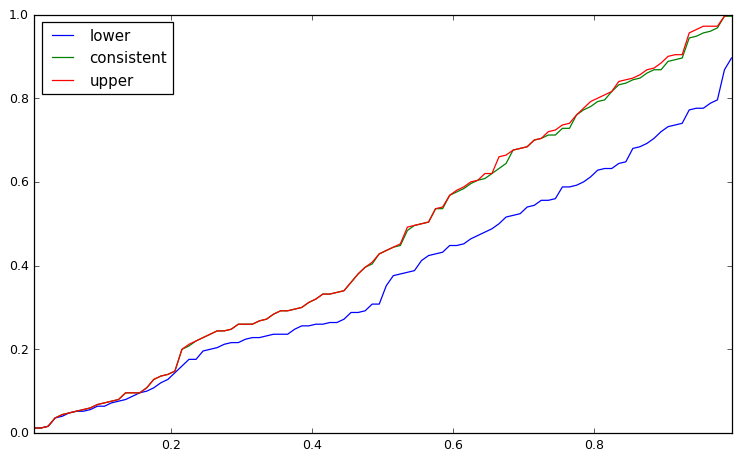

In [6]:
import pandas as pd

pvalues = pd.DataFrame(pvalues)
for col in pvalues:
    values = pvalues[col].values
    values.sort()
    pvalues[col] = values
# Change the index so that the x-values are between 0 and 1
pvalues.index = np.linspace(0.005,.995,100)
pvalues.plot()

#### Power

The SPA also has power to reject then the null is violated.  The simulation will be modified so that the amount of measurement error differs across models, and so that some models are actually better than the benchmark.   The p-values should be small indicating rejection of the null.

In [7]:
# Number of models
k = 500
model_factors = np.zeros((k,t,3))
model_losses = np.zeros((500,k))
for i in range(k):
    scale = ((2500.0 - i) / 2500.0)
    model_factors[i] = factors + scale * randn(1000,3)
    model_beta  = sm.OLS(y[:500],model_factors[i,:500]).fit().params
    # MSE loss
    model_losses[:,i] = (y[500:] - model_factors[i,500:].dot(model_beta))**2.0

spa = SPA(bm_losses, model_losses)
spa.seed(seed)
spa.compute()
spa.pvalues

lower         0.0
consistent    0.0
upper         0.0
dtype: float64

Here the average losses are plotted.  The higher index models are clearly better than the lower index models -- and the benchmark model (which is identical to model.0).

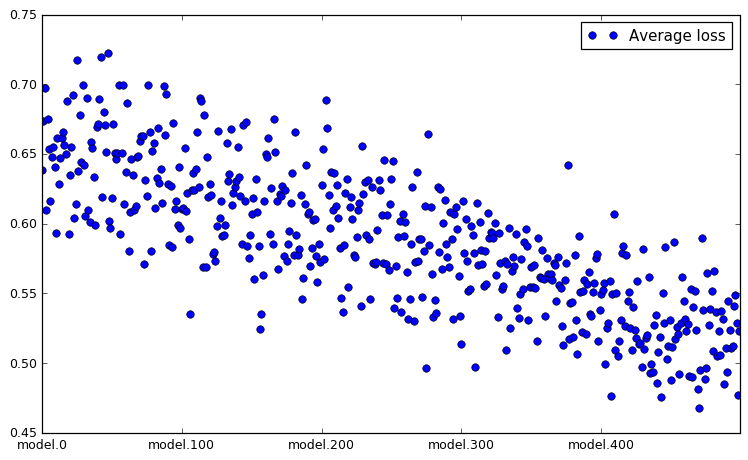

In [8]:
model_losses = pd.DataFrame(model_losses,columns=['model.' + str(i) for i in range(k)])
avg_model_losses = pd.DataFrame(model_losses.mean(0), columns=['Average loss'])
avg_model_losses.plot(style=['o'])

## Stepwise Multiple Testing (StepM)

Stepwise Multiple Testing is similar to the SPA and has the same null. The primary difference is that it identifies the set of models which are better than the benchmark, rather than just asking the basic question if any model is better.  

In [9]:
from arch.bootstrap import StepM
stepm = StepM(bm_losses, model_losses)
stepm.compute()
print(stepm.superior_models)

['model.106', 'model.152', 'model.156', 'model.157', 'model.158', 'model.186', 'model.187', 'model.197', 'model.214', 'model.215', 'model.219', 'model.228', 'model.235', 'model.248', 'model.252', 'model.254', 'model.257', 'model.261', 'model.262', 'model.263', 'model.266', 'model.272', 'model.275', 'model.279', 'model.280', 'model.281', 'model.282', 'model.294', 'model.298', 'model.299', 'model.300', 'model.305', 'model.306', 'model.310', 'model.316', 'model.318', 'model.325', 'model.326', 'model.329', 'model.330', 'model.332', 'model.335', 'model.336', 'model.340', 'model.341', 'model.342', 'model.344', 'model.348', 'model.349', 'model.351', 'model.353', 'model.354', 'model.356', 'model.357', 'model.359', 'model.360', 'model.362', 'model.363', 'model.364', 'model.365', 'model.368', 'model.370', 'model.371', 'model.372', 'model.373', 'model.374', 'model.377', 'model.378', 'model.379', 'model.380', 'model.382', 'model.383', 'model.385', 'model.386', 'model.387', 'model.388', 'model.389'

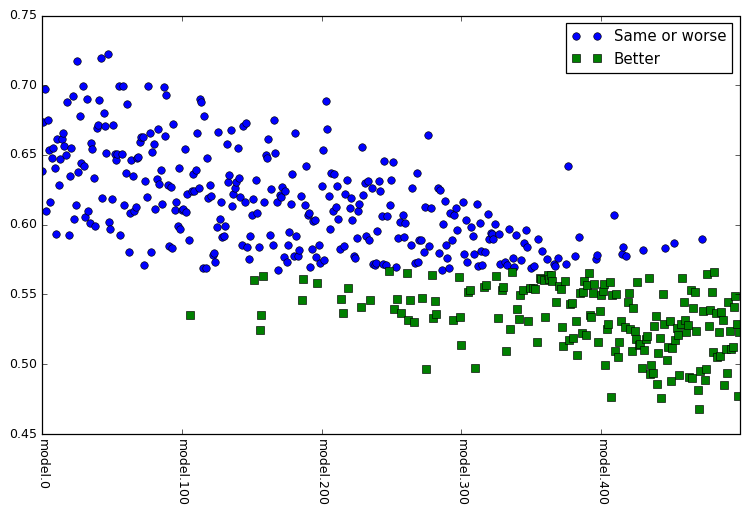

In [10]:
better_models = pd.concat([model_losses.mean(0),model_losses.mean(0)],1)
better_models.columns = ['Same or worse','Better']
better = better_models.index.isin(stepm.superior_models)
worse = np.logical_not(better)
better_models.loc[better,'Same or worse'] = np.nan
better_models.loc[worse,'Better'] = np.nan
better_models.plot(style=['o','s'], rot=270)

## The Model Confidence Set

The model confidence set takes a set of **losses** as its input and finds the set which are not statistically different from each other while controlling the familywise error rate.  The primary output is a set of p-values, where models with a pvalue above the size are in the MCS.  Small p-values indicate that the model is easily rejected from the set that includes the best.  

In [11]:
from arch.bootstrap import MCS
# Limit the size of the set
losses = model_losses.iloc[:,::20]
mcs = MCS(losses, size=0.10)
mcs.compute()
print('MCS P-values')
print(mcs.pvalues)
print('Included')
included = mcs.included
print(included)
print('Excluded')
excluded = mcs.excluded
print(excluded)

MCS P-values
            Pvalue
Model name        
model.60     0.000
model.80     0.000
model.140    0.000
model.40     0.000
model.20     0.000
model.100    0.004
model.120    0.012
model.0      0.012
model.220    0.036
model.200    0.102
model.240    0.103
model.260    0.119
model.160    0.136
model.180    0.401
model.320    0.440
model.420    0.453
model.400    0.666
model.360    0.849
model.340    0.849
model.280    0.849
model.460    0.849
model.380    0.849
model.300    0.849
model.480    0.849
model.440    1.000
Included
['model.160', 'model.180', 'model.200', 'model.240', 'model.260', 'model.280', 'model.300', 'model.320', 'model.340', 'model.360', 'model.380', 'model.400', 'model.420', 'model.440', 'model.460', 'model.480']
Excluded
['model.0', 'model.100', 'model.120', 'model.140', 'model.20', 'model.220', 'model.40', 'model.60', 'model.80']


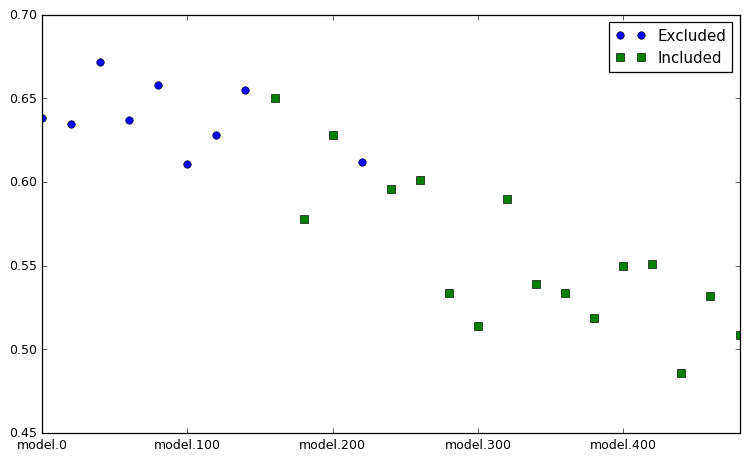

In [12]:
status = pd.DataFrame([losses.mean(0),losses.mean(0)], index=['Excluded','Included']).T
status.loc[status.index.isin(included), 'Excluded'] = np.nan
status.loc[status.index.isin(excluded), 'Included'] = np.nan
status.plot(style=['o','s'])